In [733]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

from svgpathtools import parse_path

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### Setup

In [734]:
# directory & file hierarchy
proj_dir = os.path.abspath('../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))

if not os.path.exists(results_dir):
    os.makedirs(results_dir)  

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)  
    
## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))        
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/kushin/Documents/GitHub/semantic_parts/analysis/analysis_helpers.pyc'>

#### set up connection to mongo

In [735]:
#### set vars 
import pandas as pd
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
key  = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['svgAnnotation']
coll = db['chairs4']

# which iteration name should we use?
iterationName = 'run0_chairs4'

### get some descriptive stats on our annotation data!

In [736]:
num_annotations = coll.find({'iterationName':iterationName}).count()
print 'We have {} annotations so far.'.format(num_annotations)

We have 1234 annotations so far.


#### build up annotation data csv

In [737]:
## TODO remember to ignore researcher worker ID's in our dataset
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
kmukherjee = ['A1WU4IHJNQGVAY']
researchers = jefan + hawkrobe + megsano + kmukherjee

In [738]:
## TODO use a helper function to get complete and valid HITs 

In [739]:
## categories that are in play
main_category = 'chair'
dataset = 'chairs4'

In [740]:
## get list of unique_assignments
unique_assignments = coll.find({'iterationName':iterationName}).distinct('aID')

### initialize a bunch of stuff
orig_gameID = [] # the gameID from which this sketch was sourced
orig_trial_num = [] # the trialnum in the original game from which this sketch was sourced -- 
sketch_id = [] # concatenation of orig_gameID and orig_trial_num -- 
assignmentID = [] # the session in which this annotation was collected -- 
annotation_id = [] # the unique ID for each annotation trial (different for each session the same sketch appears in)
category = [] # e.g., "chair"
target = [] # e.g., "inlay"
condition = [] # e.g., "closer" vs. "further" or "repeated" vs. "control
trial_num = []
workerID = []
spline_id =[]
time_submitted = [] # when the participant clicked "next sketch"
time_labeled = [] # unique to each spline labeled
time_clicked = [] # when this spline was clicked/selected
num_strokes_in_sketch = [] # how many strokes in this sketch
num_splines_in_sketch = [] # how many spline elements in this sketch
stroke_num = [] # which stroke number this labeled spline came from
cumulative_spline_num = [] # spline index in the cumulative spline sequence for the entire sketch
within_stroke_spline_num = [] # spline index for the current stroke
label = [] # the label provided by the participant
spline_svg_string = [] # the svg spline string that earned this label
sketch_svg_string = [] # the entire svg string correponding to this sketch
annotation_flag = [] # this is True if all splines were labeled as the same thing
annotation_spline_id = []
stroke_id=[]

## loop through all the unique assignments that have submitted things
for this_assignment, aID in enumerate(unique_assignments):
    if this_assignment%50==0:
        print 'Analyzing sketches from assignment {} of {}  ...'.format(this_assignment, len(unique_assignments))

    ### get all the sketch recs for this assignment
    sketch_recs = coll.find({'$and': [{'iterationName':iterationName}, {'aID':aID}]}).sort('time')

    try:

        for sketch_ind,sketch in enumerate(sketch_recs):
            ## get annotations embedded within record
            annotations_string = sketch['annotations']  
            ## convert to json dictionary
            _annotations_dict = json.loads(annotations_string)   
            annotations_dict = _annotations_dict[0][main_category]
            num_splines = len(annotations_dict)
            for annotation in annotations_dict:
                assert sketch['numSplines']==num_splines                
                ## get spline-level metadata
                workerID.append(h.encode(key,sketch['wID']))
                label.append(annotation['label'])
                stroke_num.append(annotation['strokeNum'])
                spline_svg_string.append(annotation['svgString'])
                cumulative_spline_num.append(annotation['cumulativeSplineNum'])
                within_stroke_spline_num.append(annotation['withinStrokeSplineNum'])
                time_clicked.append(annotation['timeClicked'])
                time_labeled.append(annotation['timeLabeled'])
                spline_id.append('{}_{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum'],annotation['cumulativeSplineNum']))
                stroke_id.append('{}_{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum'],annotation['strokeNum']))
                ## get sketch-level metadata
                orig_gameID.append(sketch['originalGameID'])   
                orig_trial_num.append(sketch['originalTrialNum'])
                sketch_id.append('{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum']))
                annotation_id.append('{}_{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum'],sketch['aID']))
                assignmentID.append(sketch['aID'])
                category.append(sketch['category'])
                target.append(sketch['target'])
                condition.append(sketch['condition'])
                time_submitted.append(sketch['time'])
                trial_num.append(sketch['trialNum'])
                num_splines_in_sketch.append(sketch['numSplines'])
                num_strokes_in_sketch.append(sketch['numStrokes'])
                sketch_svg_string.append(sketch['svg'])
                annotation_flag.append(sketch['sameAnnotflag'])
                annotation_spline_id.append('{}_{}_{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum'],sketch['aID'],annotation['cumulativeSplineNum']))
                
    except AssertionError:
        print 'There were unequal numbers for sketch["numSplines"] vs. num_splines for sketch {} from {}'.\
                format(sketch['trialNum'], sketch['aID'])


Analyzing sketches from assignment 0 of 135  ...
Analyzing sketches from assignment 50 of 135  ...
There were unequal numbers for sketch["numSplines"] vs. num_splines for sketch 0 from 336YQZE83WS2132FW9VT3OWTC0UM5V
There were unequal numbers for sketch["numSplines"] vs. num_splines for sketch 1 from 3AMYWKA6YC0MKAN5E8KBNYZY3VL6OB
There were unequal numbers for sketch["numSplines"] vs. num_splines for sketch 3 from 3CTOC39K384RNZADH5XYLGI8ZCV7JS
Analyzing sketches from assignment 100 of 135  ...
There were unequal numbers for sketch["numSplines"] vs. num_splines for sketch 6 from 3GNA64GUZFITMI07O22AKXGYM25Q52
There were unequal numbers for sketch["numSplines"] vs. num_splines for sketch 7 from 3MH9DQ757XQJU8W8M756YV4CFXAGU2


In [742]:
## make group data csv 
D = pd.DataFrame([workerID,orig_gameID, orig_trial_num, sketch_id, category, assignmentID,  target, \
                  annotation_id, condition, trial_num, time_submitted,\
                 time_labeled, time_clicked, num_strokes_in_sketch, num_splines_in_sketch,\
                 stroke_num, cumulative_spline_num, within_stroke_spline_num, label,\
                 spline_svg_string, sketch_svg_string, spline_id, stroke_id, annotation_spline_id])
D = D.transpose()
D.columns = ['workerID','orig_gameID', 'orig_trial_num', 'sketch_id', 'category', 'assignmentID', 'target',\
             'annotation_id', 'condition', 'trial_num', 'time_submitted',\
             'time_labeled', 'time_clicked', 'num_strokes_in_sketch', 'num_splines_in_sketch',\
             'stroke_num', 'cumulative_spline_num', 'within_stroke_spline_num', 'label',\
             'spline_svg_string', 'sketch_svg_string', 'spline_id','stroke_id','annotation_spline_id']

print 'Annotations dataframe contains {} rows and {} columns.'.format(D.shape[0],D.shape[1])

Annotations dataframe contains 28474 rows and 24 columns.


In [600]:
## save out csv to results dir
D.to_csv(os.path.join(results_dir,'svg_annotations_{}.csv'.format(dataset)))

#### get descriptive stats on annotation data

In [743]:
## Some starting questions about sketchpad_basic dataset

## Annotation task
## How consistent are annotators for the same object? Inter-rater reliability

## Content
## What does the part distribution look like for each object? Presence/absence.
## How does the part distribution differ between contexts, matched by object?

## Contenty Style
## Here we might use arc length as a measure of how much was expended for each part.
## How much arc length is spent on each part 
## Is the entropy of the part distribution (measuring arc length) different for close trials than far trials?

## Dynamics
## Are people drawing each part "in succession?" (Do people plan & execute their drawings in terms of parts?)
## Are people starting out producing longer strokes, than shorter strokes? Look at time series within 
## sketch for the arc lengths of strokes produced .... 

### Make visualizations of dataset

##### How many sketches do we have annotated?

In [744]:
unique_sketches = np.unique(D['sketch_id'].values)
print 'We have {} unique sketches.'.format(len(unique_sketches))

We have 370 unique sketches.


#### Number of times each sketch has been annotated

(0, 5)

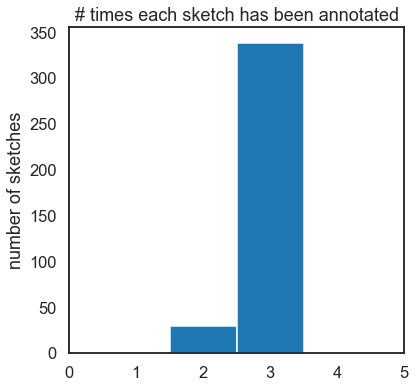

In [745]:
## get number of times it has been annotated
num_times_annotated = []
for this_sketch_id in unique_sketches:
    num_times_annotated.append(D[D['sketch_id']==this_sketch_id]['annotation_id'].nunique())
    
## make a histogram
sns.set_context('talk')
plt.figure(figsize=(6,6))
h = plt.hist(num_times_annotated, bins=range(5), align='left')
plt.title('# times each sketch has been annotated')
plt.ylabel('number of sketches')
plt.xlim(0,5)



##### check to make sure that for each sketch, you have a unique number of splines associated with it

In [702]:
unique_sketches = np.unique(D['sketch_id'].values)
for this_sketch in unique_sketches:
    assert len(np.unique(D[D['sketch_id']==this_sketch]['num_splines_in_sketch'].values))==1

##### How long do sketches take to annotate? Do more complex sketches (i.e., those consisting of more splines) take longer to annotate? [Sanity check]

In [ ]:
#### first, we will get the amount of time taken to annotate each sketch
unique_annotation_trials = np.unique(D['annotation_id'].values)

In [703]:
## get annotation time for each annotation trial
annotation_time = []
spline_number_in_sketch = []

for this_annotation_trial in unique_annotation_trials:
    earliest_click = float(np.min(D[D['annotation_id']==this_annotation_trial]['time_clicked']))
    ## all of the splines were submitted at the same time, so time_submitted should be identical for all splines in an annotation trial
    assert len(np.unique(D[D['annotation_id']==this_annotation_trial]['time_submitted'].values))==1
    final_submission = np.unique(D[D['annotation_id']==this_annotation_trial]['time_submitted'].values)[0]
    annotation_time.append(final_submission-earliest_click)        
    if np.isnan(final_submission) or np.isnan(earliest_click):
        print 'One of these timestamps is a NaN. Probably means that the participant skipped this trial:'
        print this_annotation_trial
        print 'final_submission: {}, earliest_click: {}'.format(final_submission, earliest_click)
    #### then we will extract how "complex" each sketch i
    assert len(np.unique(D[D['annotation_id']==this_annotation_trial]['num_splines_in_sketch'].values))==1    
    spline_number_in_sketch.append(np.unique(D[D['annotation_id']==this_annotation_trial]['num_splines_in_sketch'])[0])
    

One of these timestamps is a NaN. Probably means that the participant skipped this trial:
5707-49e9e7c8-5fe1-4469-9905-4ba89ccde7dd_17_34QN5IT0T05OL7EA52FYHBZ7BO880O
final_submission: 1.53368507963e+12, earliest_click: nan


AssertionError: 

In [704]:
## convert annotation time to seconds
annotation_time_seconds = np.array(annotation_time)/1000

## make dataframe with annotation time and spline number
unique_annotation_trials, spline_number_in_sketch, annotation_time_seconds = map(list, [unique_annotation_trials, spline_number_in_sketch, annotation_time_seconds])
T = pd.DataFrame([unique_annotation_trials,spline_number_in_sketch,annotation_time_seconds])
T = T.transpose()
T.columns = ['annotation_trial','spline_number_in_sketch','annotation_time']

## some preprocessing of T
reload(h)

## make numeric types
T = h.convert_numeric(T,'spline_number_in_sketch')
T = h.convert_numeric(T,'annotation_time')

## also remove the skipped trial where annotation time is a NaN
T = T[~np.isnan(T['annotation_time'])]

TypeError: reload() argument must be module

(0, 300)

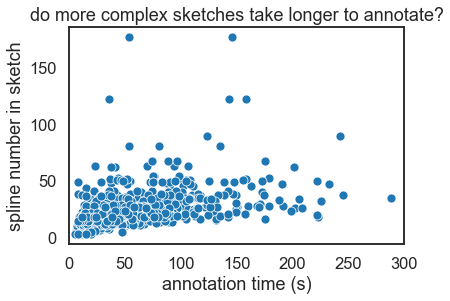

In [705]:
## make scatterplot of relationship between annotation time and spline number
sns.scatterplot(x='annotation_time',
                y='spline_number_in_sketch',
                data=T)
plt.ylabel('spline number in sketch')
plt.xlabel('annotation time (s)')
plt.title('do more complex sketches take longer to annotate?')
plt.xlim(0,60*5) ## 5 minute cutoff ...

In [706]:
r, p = stats.spearmanr(T['annotation_time'],T['spline_number_in_sketch'])
print 'Spearman correlation between annotation time and spline number in sketch' 
print 'r = {}, p = {}'.format(r,p)

Spearman correlation between annotation time and spline number in sketch
r = 0.506777671106, p = 2.37782279074e-79


/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


##### Make histogram of part word occurrence distribution

In [707]:
## get the list of unique labels applied to chairs
unique_labels = np.unique(D.label.values)

## some deborkification of the unique label list
unique_labels = [i for i in unique_labels if i is not None]
unique_labels = [i for i in unique_labels if len(i)<900]

proper_labels = []

In [708]:
print 'After some light deborkificiation, there are {} unique part labels in our dataset.'.format(len(unique_labels))

After some light deborkificiation, there are 93 unique part labels in our dataset.


In [709]:
## create a dataframe that is [num_sketches x num_labels] where each cell is incremented by 1
## when that part word appears as an annotation to that sketch
unique_labels = np.array(unique_labels)

In [710]:
unique_labels

array([u'Armrest + leg', u'Brace', u'Chair Details', u'Cushion',
       u'Cushion ', u'Decoration', u'Design', u'Feet', u'Frame',
       u'Leg + part of backrest', u'Leg Support', u'Leg stabilizers',
       u'Leg support ', u'Legs and Frame', u'Lower leg strut',
       u'Metal cross bar', u'Neck Support', u'Neck rest',
       u'Not part of chair', u'Rung',
       u'Someone\'s attempt to write "Orange," and an arrow.', u'Spoke',
       u'Stabilizer', u'Stile', u'Support', u'Support Bar',
       u'Support beam', u'Supports', u'Wheel', u'Wooden cross bar',
       u'Wooden cross bars', u'Word orange', u'Words',
       u'a word and an arrow', u'arm', u'armrest', u'armrest and leg',
       u'armrest support', u'arrow', u'back support', u'backrest',
       u'backrest bar', u'bar', u'bar across front under seat', u'bars',
       u'brace', u'braces', u'cashion', u'caster', u'cross bar',
       u'cross suppor', u'cross support', u'crossbar', u'cushion',
       u'decor', u'design', u'design on ch

In [711]:
## initialize matrix that has the correct dimensions
Label_Vec = np.zeros((len(unique_sketches),len(unique_labels)), dtype=int)

for s,this_sketch in enumerate(unique_sketches):
    label_vec = np.zeros(len(unique_labels),dtype=int)
    DS = D[D['sketch_id']==this_sketch]
    annotation_ids = np.unique(DS['annotation_id'].values)    
    for this_annotation in annotation_ids:
        DSA = DS[(DS['sketch_id']==this_sketch) & (DS['annotation_id']==this_annotation)]
        label_list = np.unique(DSA.label.values)
        for this_label in label_list:
            label_ind = unique_labels==this_label
            label_vec[label_ind] += 1
    Label_Vec[s,:]=label_vec                    

In [712]:
thresh = 50
print 'These are the labels that appear at least {} times:'.format(thresh)
print unique_labels[np.sum(Label_Vec,0)>thresh]
plot_labels=unique_labels[np.sum(Label_Vec,0)>thresh]



These are the labels that appear at least 50 times:
[u'armrest' u'backrest' u'leg' u'seat' u'unknown']


In [713]:
plot_labels

array([u'armrest', u'backrest', u'leg', u'seat', u'unknown'], dtype='<U50')

In [714]:
num_labels=[]
for part in plot_labels:
    num_labels.append(D[D['label']==part]['annotation_id'].nunique())
num_labels

[508, 1163, 1147, 1169, 89]

Text(0,0.5,'number of annotations')

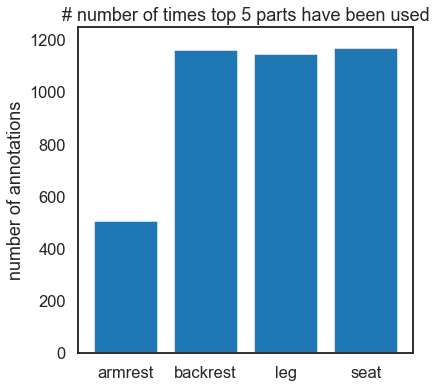

In [665]:
sns.set_context('talk')
plt.figure(figsize=(6,6))
plt.ylim(0,1250)
h = plt.bar(plot_labels,num_labels)
plt.title('# number of times top 5 parts have been used')
plt.ylabel('number of annotations')


##### Build a dataframe that vectorizes each annotation trial into the presence/absence of a part label [num_annotation_trials x num_words_in_lexicon]


In [ ]:
unique_annotations = np.unique(D['annotation_id'])
unique_labels = np.unique(D['label'])
Label_Vec = np.zeros((len(unique_annotations),len(unique_labels)), dtype=int)

for s,this_annotation in enumerate(unique_annotations):
    label_vec = np.zeros(len(unique_labels),dtype=int)
    DS = D[D['annotation_id']==this_annotation]
    label_list = np.unique(DS.label.values)
    for this_label in label_list:
        label_ind = unique_labels==this_label
        label_vec[label_ind] += 1
    Label_Vec[s,:]=label_vec                    

In [ ]:
L = pd.DataFrame(data=Label_Vec, columns = unique_labels )

In [ ]:
##Working at the unique sketch level Setting up presence absence df
L[L==0]= False
L[L>0]= True

##### Build a dataframe that vectorizes each spline into the count of each part label [num_splines_in_dataset x num_words_in_lexicon]

In [ ]:
unique_splines = np.unique(D['annotation_spline_id'])
Label_Vec = np.zeros((len(unique_splines),len(unique_labels)), dtype=int)

for s,this_spline in enumerate(unique_splines):
    label_vec = np.zeros(len(unique_labels),dtype=int)
    DS = D[D['annotation_spline_id']==this_spline]
    label_list = np.unique(DS.label.values)
    for this_label in label_list:
        label_ind = unique_labels==this_label
        label_vec[label_ind] += 1
    Label_Vec[s,:]=label_vec    

In [ ]:
M = pd.DataFrame(data= Label_Vec, columns = unique_labels)

##### Analysis for presentation


In [ ]:
##Filtering for sketches that have only been annotated 3 times
for this_sketch_id in unique_sketches:
    if D[D['sketch_id']==this_sketch_id]['annotation_id'].nunique()!=3:
        D=D[D['sketch_id']!=this_sketch]

In [747]:
unique_sketches = np.unique(D['sketch_id'])

In [748]:
## Getting the number of unique labels assigned to a given spline across annotations

valid_labels = ['backrest','armrest','seat','leg']
D=D[D.label.isin(valid_labels)]

num_diff_annots = []
for this_sketch_id in unique_sketches:
    DS=D[D['sketch_id']==this_sketch_id]
    unique_splines = np.unique(DS['cumulative_spline_num'])
    for i,this_spline in enumerate(unique_splines):
        DSS =DS[DS['cumulative_spline_num']==this_spline]
        numannots= 4-len(np.unique(DSS['label']))
        if numannots==1:
            numannots=0
        num_diff_annots.append(numannots)
            
    

Text(0.5,0,'Agreement on label (out of 3)')

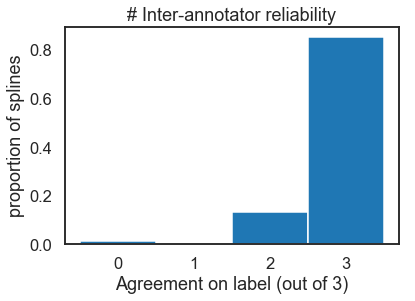

In [778]:
#plotting variability in spline annots
h= plt.hist(num_diff_annots, bins= range(5), align='left', density='True')
plt.title('# Inter-annotator reliability')
plt.ylabel('proportion of splines')
plt.xlabel('Agreement on label (out of 3)')

In [732]:
##Generating an array of modal label for a spline along with its corresponding spline_id

valid_labels = np.array(['backrest','armrest','seat','leg'])
D=D[D.label.isin(valid_labels)]
gt_labels=np.zeros((1,2))

for this_sketch_id in unique_sketches:
    DS=D[D['sketch_id']==this_sketch_id]
    unique_splines = np.unique(DS['cumulative_spline_num'].values)
    for i,this_spline in enumerate(unique_splines):
        label_counter = np.zeros(len(valid_labels))
        DSS =DS[DS['cumulative_spline_num']==this_spline]
        unique_annots= np.unique(DSS['annotation_id'].values)
        for this_annot in unique_annots:
            for label in valid_labels:
                if DSS.loc[DSS['annotation_id']==this_annot,'label'].values[0]==label:
                    label_counter[np.where(valid_labels==label)]+=1
        entry = np.array([valid_labels[np.argmax(label_counter)],DSS.loc[DSS['annotation_id']==this_annot, 'spline_id'].values[0]])
        gt_labels = np.vstack((gt_labels,entry))
                    
                  
            
    

In [670]:
#Getting number of unique labels assigned to the constituent splines of each unique stroke
valid_labels = ['backrest','armrest','seat','leg']
D=D[D.label.isin(valid_labels)]


spline_annots_per_stroke = []
for this_sketch_id in unique_sketches:
    DS=D[D['sketch_id']==this_sketch_id]
    unique_strokes = np.unique(DS['stroke_num'])
    for i,this_stroke in enumerate(unique_strokes):
        DSS =DS[DS['stroke_num']==this_stroke]
        unique_splines = np.unique(DSS['spline_id'])
        numlabels=[]
        for this_spline in unique_splines:
            ind=np.where(gt_labels==this_spline)
            numlabels.append(gt_labels[ind[0],ind[1]-1])
        numannots= len(np.unique(numlabels))
        spline_annots_per_stroke.append(numannots)

        

stroke 0
stroke 1
stroke 2
stroke 0
stroke 1
stroke 2
stroke 0
stroke 1
stroke 2
stroke 0
stroke 1
stroke 2
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 11
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 11
stroke 12
stroke 13
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 0
stroke 1
stroke 2
stroke 3
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 11
stroke 12
stroke 13
stroke 14
stroke 15
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 0
stroke 1
stroke 2
stroke 3
stroke

stroke 4
stroke 5
stroke 6
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 11
stroke 12
stroke 13
stroke 14
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 11
stroke 12
stroke 13
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 11
stroke 12
stroke 13
stroke 14
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 0
stro

stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 11
stroke 12
stroke 13
stroke 14
stroke 15
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 11
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 11
stroke 12
stroke 13
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 0
stroke 1
stroke 2
stroke 3
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 0
stroke

stroke 13
stroke 14
stroke 15
stroke 16
stroke 17
stroke 18
stroke 19
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 11
stroke 12
stroke 13
stroke 14
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 11
stroke 12
stroke 13
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 0
stroke 1
stroke 0
stroke 1
stroke 2
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 10
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 0
stroke 1
stroke 2
stroke 3
stroke 4
stroke 5
stroke 6
stroke 7
stroke 8
stroke 9
stroke 0
stroke 1
stroke 2
stroke 3
st

Text(0.5,0,'number of different labels')

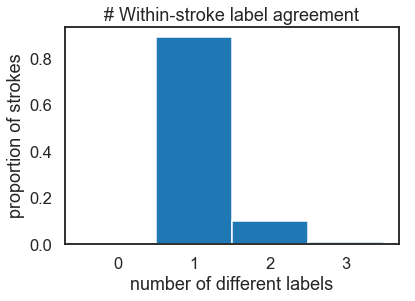

In [775]:
##Visualizing variability in spline annotations within strokes
h= plt.hist(spline_annots_per_stroke, bins =range(5), align='left', density="True")
plt.title('# Within-stroke label agreement')
plt.ylabel('proportion of strokes')
plt.xlabel('number of different labels')

In [750]:
D.groupby(['sketch_id','stroke_num'])['annotation_id'].describe()
gt_stroke_labels=np.zeros((1,2))

for this_sketch in unique_sketches:
    DS=D[D['sketch_id']==this_sketch]
    unique_strokes=np.unique(DS['stroke_num'])
    for this_stroke in unique_strokes:
        label_counter = np.zeros(len(valid_labels))
        DSS= DS[DS['stroke_num']==this_stroke]
        unique_annots= np.unique(DSS['annotation_id'])
        for this_annot in unique_annots:
            for label in valid_labels:
                if DSS.loc[DSS['annotation_id']==this_annot,'label'].values[0]==label:
                    label_counter[np.where(valid_labels==label)]+=1
        entry = np.array([valid_labels[np.argmax(label_counter)],DSS.loc[DSS['annotation_id']==this_annot, 'stroke_id'].values[0]])
        gt_stroke_labels = np.vstack((gt_stroke_labels,entry))
        

In [ ]:
valid_labels = ['backrest','armrest','seat','leg']
D=D[D.label.isin(valid_labels)]


spline_annots_per_stroke = []
for this_sketch_id in unique_sketches:
    DS=D[D['sketch_id']==this_sketch_id]
    unique_strokes = np.unique(DS['stroke_num'])
    for i,this_stroke in enumerate(unique_strokes):
        DSS =DS[DS['stroke_num']==this_stroke]
        unique_splines = np.unique(DSS['spline_id'])
        numlabels=[]
        for this_spline in unique_splines:
            ind=np.where(gt_labels==this_spline)
            numlabels.append(gt_labels[ind[0],ind[1]-1])
        numannots= len(np.unique(numlabels))
        spline_annots_per_stroke.append(numannots)

        

In [ ]:
h=sns.distplot(spline_annots_per_stroke,hist=True, kde=False, bins=range(5))
plt.title('# Variability in spline annotations within strokes')
plt.ylabel('number of strokes')
plt.xlabel('number of labels')